In [113]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import geopandas as gpd


In [83]:
pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2022` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))
df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df=df[(df['Mention_country'].isin(possible_iso))&(df['Aff_country'].isin(possible_iso))]
df=df[df['year']<=2020]

In [84]:
self_df=df[df['Mention_country']==df['Aff_country']].drop(columns=['Aff_country']).rename(columns={'count':'self_attention', 'Mention_country':'country'})
in_df=df[df['Mention_country']!=df['Aff_country']].groupby(by=['Mention_country', 'subjarea', 'year'])['count'].sum().reset_index().rename(columns={'count':'recieved_attention', 'Mention_country':'country'})
out_df=df[df['Mention_country']!=df['Aff_country']].groupby(by=['Aff_country', 'subjarea', 'year'])['count'].sum().reset_index().rename(columns={'count':'given_attention', 'Aff_country':'country'})
final_df=self_df.merge(in_df, how='outer', on=['country', 'year', 'subjarea']).merge(out_df, how='outer', on=['country', 'year', 'subjarea']).fillna(0)
###########
final_df=final_df.groupby('country').agg({'self_attention':'sum', 'recieved_attention':'sum', 'given_attention':'sum'}).reset_index()
final_df['total_recieved']=final_df['self_attention']+final_df['recieved_attention']
final_df['total_given']=final_df['self_attention']+final_df['given_attention']

In [85]:
final_df['ABI'] = (final_df['total_recieved'] - final_df['total_given']) / \
                  (final_df['total_recieved'] + final_df['total_given'] + 1e-9)

final_df['SRR'] = final_df['self_attention'] / (final_df['total_recieved'] + 1e-9)

final_df['SI'] = (final_df['self_attention'] + 
                  np.minimum(final_df['total_recieved'], final_df['total_given'])) / \
                 (final_df['self_attention'] + final_df['total_recieved'] + final_df['total_given'] + 1e-9)

In [101]:
data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'country'}, inplace=True)
data['country']=data['country'].apply(lambda x: x.lower())
data=data.groupby(by=['incomelevel', 'country','region']).agg({'gdp_per_capita':'mean', 'population':'mean', 'padded_population_of_researchers':'mean'}).reset_index()
df=final_df.merge(data, on=['country'], how='left')

<Axes: xlabel='ABI', ylabel='region'>

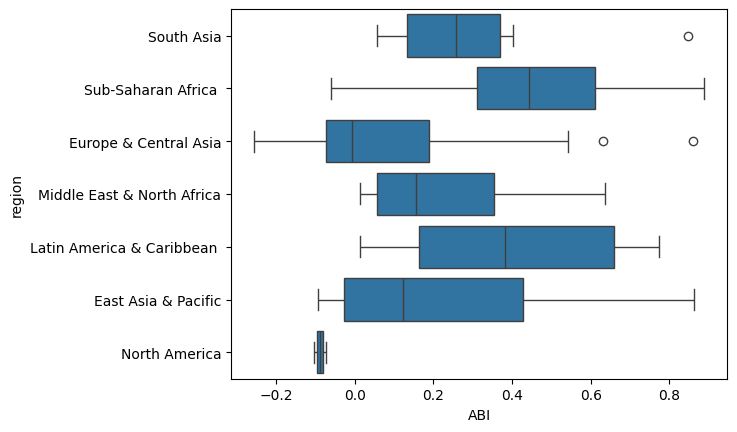

In [109]:
sns.boxplot(data=df, y='region', x='ABI')

<Axes: xlabel='incomelevel', ylabel='ABI'>

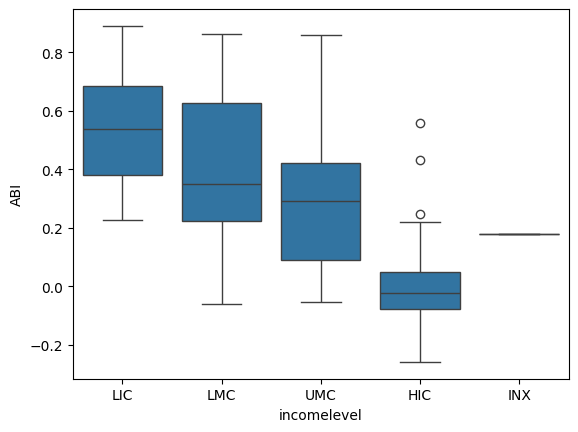

In [104]:
sns.boxplot(data=df, x='incomelevel', y='ABI')

<Axes: xlabel='incomelevel', ylabel='SI'>

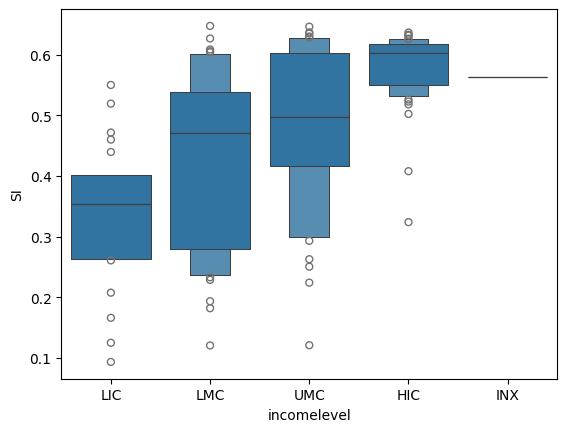

In [106]:
sns.boxenplot(data=df, x='incomelevel', y='SI')

<Axes: xlabel='incomelevel', ylabel='SRR'>

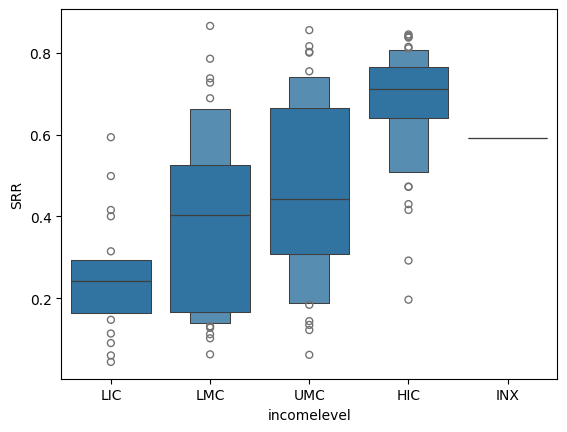

In [107]:
sns.boxenplot(data=df, x='incomelevel', y='SRR')

In [117]:
df['country']=df['country'].apply(lambda x: x.upper())

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_44392\4011012355.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



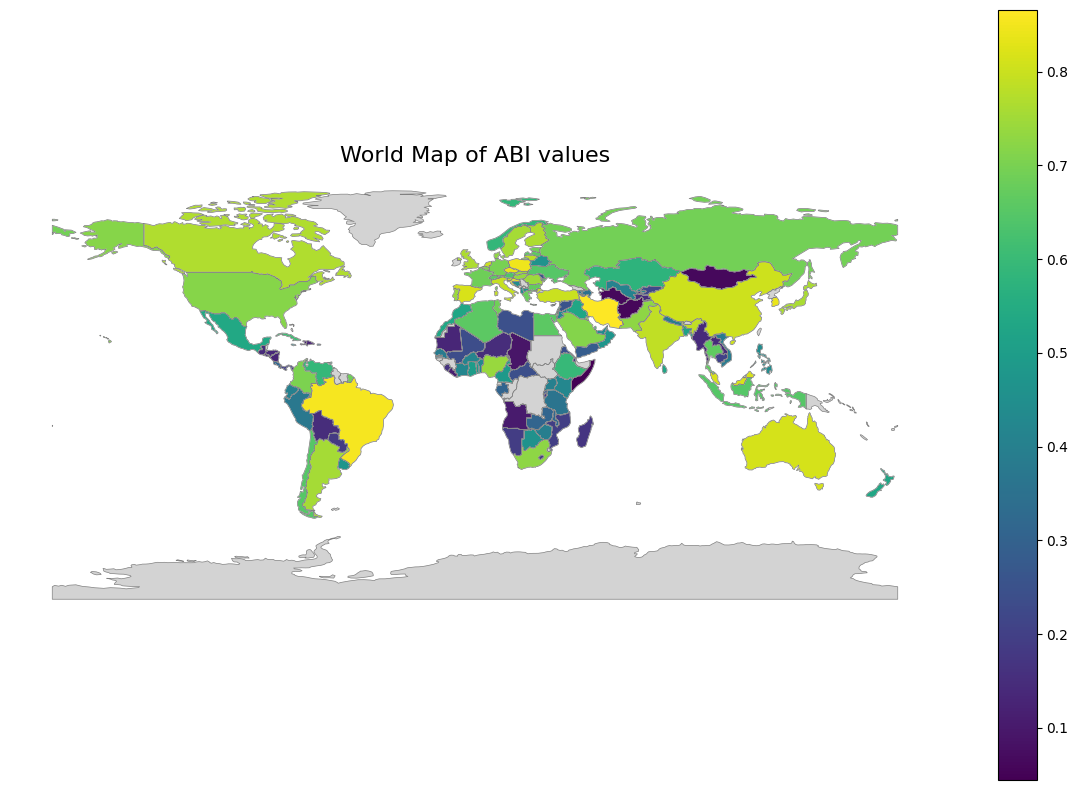

In [123]:

# Load world map (using geopandas built-in dataset)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Merge ABI values into world map by ISO_A3 code
world = world.merge(df, how="left", left_on="iso_a3", right_on="country")

# Plot ABI values
fig, ax = plt.subplots(figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=0.5, color="gray")
world.plot(column="SRR", cmap="viridis", linewidth=0.5, ax=ax, edgecolor="0.9", legend=True, missing_kwds={"color": "lightgrey"})
ax.set_title("World Map of ABI values", fontsize=16)
ax.axis("off")
plt.show()

In [124]:
df

,country,self_attention,recieved_attention,given_attention,total_recieved,total_given,ABI,SRR,SI,incomelevel,region,gdp_per_capita,population,padded_population_of_researchers
0,AFG,287.723714,4482.929491,105.489910,4770.653204,393.213623,0.847706,0.060311,0.124906,LIC,South Asia,431.247390,2.840399e+07,154.318182
1,AGO,198.664263,1744.814141,34.777944,1943.478404,233.442207,0.785530,0.102221,0.181895,LMC,Sub-Saharan Africa,2470.965963,2.323220e+07,111.782609
2,ALB,973.173573,1227.530802,167.082735,2200.704374,1140.256308,0.317408,0.442210,0.489885,UMC,Europe & Central Asia,3392.698561,2.958454e+06,590.391304
3,ARE,3810.850521,5049.462306,2621.915186,8860.312827,6432.765707,0.158735,0.430103,0.536205,HIC,Middle East & North Africa,38822.422027,6.615256e+06,3378.826087
4,ARG,28406.611821,9232.662268,6511.908116,37639.274089,34918.519937,0.037498,0.754707,0.627203,UMC,Latin America & Caribbean,9109.862821,4.069060e+07,30447.739130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,VNM,8083.658941,13173.885220,1708.506128,21257.544161,9792.165069,0.369259,0.380272,0.456792,LMC,East Asia & Pacific,1618.434497,8.676922e+07,6476.434783
141,YEM,648.756813,1637.883801,172.233095,2286.640614,820.989909,0.471630,0.283716,0.391266,LIC,Middle East & North Africa,903.667838,2.439092e+07,358.434783
142,ZAF,46714.248687,17718.697082,15666.044821,64432.945768,62380.293507,0.016186,0.725006,0.628687,UMC,Sub-Saharan Africa,5815.279354,5.173774e+07,22274.695652
143,ZMB,1493.484996,3357.851029,281.720301,4851.336025,1775.205297,0.464214,0.307850,0.402547,LMC,Sub-Saharan Africa,1066.544667,1.360670e+07,701.391304
